In [1]:
import csv
import os
import os.path
import tarfile
from urllib.parse import urlparse
import warnings
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
import pickle
import util
from util import *
import torchvision.transforms as transforms
import transformers 
warnings.filterwarnings('ignore')
object_categories = ["waste_bag","metal","shoe","plastic","bottle","carton","lile","galss"]




def read_image_label(file):
    print('[dataset] read ' + file)
    data = dict()
    with open(file, 'r') as f:
        for line in f:
            tmp = line.split(' ')
            name = tmp[0]
            label = int(tmp[-1])
            data[name] = label
            #data.append([name, label])
            #print('%s  %d' % (name, label))
    return data


def read_object_labels(root, dataset, set):
    path_labels = os.path.join(root, 'VOCdevkit', dataset, 'ImageSets', 'Main')
    labeled_data = dict()
    num_classes = len(object_categories)

    for i in range(num_classes):
        file = os.path.join(path_labels, object_categories[i] + '_' + set + '.txt')
        data = read_image_label(file)

        if i == 0:
            for (name, label) in data.items():
                labels = np.zeros(num_classes)
                labels[i] = label
                labeled_data[name] = labels
        else:
            for (name, label) in data.items():
                labeled_data[name][i] = label

    return labeled_data


def write_object_labels_csv(file, labeled_data):
    # write a csv file
    print('[dataset] write file %s' % file)
    with open(file, 'w') as csvfile:
        fieldnames = ['name']
        fieldnames.extend(object_categories)
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for (name, labels) in labeled_data.items():
            example = {'name': name}
            for i in range(8):
                example[fieldnames[i + 1]] = int(labels[i])
            writer.writerow(example)

    csvfile.close()


def read_object_labels_csv(file, header=True):
    images = []
    num_categories = 0
    print('[dataset] read', file)
    with open(file, 'r') as f:
        reader = csv.reader(f)
        rownum = 0
        for row in reader:
            if header and rownum == 0:
                header = row
            else:
                if num_categories == 0:
                    num_categories = len(row) - 1
                name = row[0]
                labels = (np.asarray(row[1:num_categories + 1])).astype(np.float32)
                labels = torch.from_numpy(labels)
                item = (name, labels)
                images.append(item)
            rownum += 1
#     import pdb; pdb.set_trace()
    return images


def find_images_classification(root, dataset, set):
    path_labels = os.path.join(root, 'VOCdevkit', dataset, 'ImageSets', 'Main')
    images = []
    file = os.path.join(path_labels, set + '.txt')
    with open(file, 'r') as f:
        for line in f:
            images.append(line)
    return images


##-------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------


def extract_labels(target_list, object_categories):
    extracted_labels = [object_categorie for index, object_categorie in zip(target_list, object_categories) if index == 1]
    texts = []
    
    if not extracted_labels:
        str = ""
        texts.append(str)
    elif len(extracted_labels) == 1:
        str =  ", ".join(extracted_labels)
        texts.append(str)
    else:
        str = ", ".join(extracted_labels[:-1]) + " and " + extracted_labels[-1]
        texts.append(str)
    return texts


def make_textemb(texts):
    bert_path = '/model/zfr888/dual/bert-base-uncased'##****
    model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, bert_path)
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    texts_embed = model_class.from_pretrained(pretrained_weights)
    texts_tokenizer = [tokenizer(c) for c in texts]
    
    texts_input_ids = [encoding.input_ids for encoding in texts_tokenizer]
    texts_input_ids = torch.stack(texts_input_ids)
    
    with torch.no_grad():
        texts_embedding = texts_embed(texts_input_ids).last_hidden_state
    
    return texts_embedding


##-------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------


class Voc2007Classification(data.Dataset):
    def __init__(self, root, set, transform=None, target_transform=None, inp_name=None, adj=None):
        self.root = root
        self.path_devkit = os.path.join(root, 'VOCdevkit')
        self.path_images = os.path.join(root, 'VOCdevkit', 'VOC2007', 'JPEGImages')
        self.set = set
        self.transform = transform
        self.target_transform = target_transform
        
        
        
        
        
        
        # define path of csv file
        path_csv = os.path.join(self.root, 'files', 'VOC2007')
        # define filename of csv file
        file_csv = os.path.join(path_csv, 'classification_' + set + '.csv')

        # create the csv file if necessary
        if not os.path.exists(file_csv):
            if not os.path.exists(path_csv):  # create dir if necessary
                os.makedirs(path_csv)
            # generate csv file
            labeled_data = read_object_labels(self.root, 'VOC2007', self.set)
            # write csv file
            write_object_labels_csv(file_csv, labeled_data)

        self.classes = object_categories
        self.images = read_object_labels_csv(file_csv)
        
        if isinstance('/code/waste/waste_zero_shot/label_file.txt', str):
            with open('/code/waste/waste_zero_shot/label_file.txt', 'r', encoding='utf-8') as f:
                lines = f.readlines()
            self.categories = [{"id": int(line.strip().split(' ')[-1]), "name": line.strip().split(' ')[0]} for line in lines]
        self.data_transforms = {
            'trainval': transforms.Compose([transforms.Resize((224,224)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ]),
            'test': transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
            }

        print('[dataset] VOC 2007 classification set=%s number of classes=%d  number of images=%d' % (
            set, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        path, target = self.images[index]
        img = Image.open(os.path.join(self.path_images, path + '.jpg')).convert('RGB')
        target = target.tolist()
        target =  [0 if x == -1 else x for x in target]
        targets = target
        target = np.array(target)
        
        img = self.data_transforms[self.set](img)
        text = extract_labels(targets,object_categories)
        text = "This is an image of kitchen waste containing " + text[0] + "."
        
        return img, target, text

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[dataset] read /data/zfr888/ljt/voc_my_data/files/VOC2007/classification_trainval.csv
[dataset] VOC 2007 classification set=trainval number of classes=8  number of images=2525


In [7]:
from PIL import Image
import torch

import torch.nn as nn
from dataset import *
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import numpy as np
import tqdm
from torch.autograd import Variable
from metrics import *
from asl import *

from model import *


model = CustomCLIP(object_categories )
model = model.cuda()
def collate_fn(data):
    bert_path = '/model/zfr888/dual/bert-base-uncased'  # 指定 BERT 模型路径
    model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, bert_path)
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

    
    inputs = [i[0] for i in data]
    labels = [i[1] for i in data]
    sents = [i[2] for i in data]
    labels = torch.tensor(labels)
    inputs = torch.tensor([item.cpu().detach().numpy() for item in inputs]).cuda()
    
    #编码
    data = tokenizer.batch_encode_plus(batch_text_or_text_pairs=sents,
                                   truncation=True,
                                   padding='max_length',
                                   max_length=32,
                                   return_tensors='pt',
                                   return_length=True)

    #input_ids:编码之后的数字
    #attention_mask:是补零的位置是0,其他位置是1
    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    token_type_ids = data['token_type_ids']

    return input_ids, attention_mask, token_type_ids, inputs, labels

###------------------------------------------------------------------------------------------


train_dataset =  Voc2007Classification('/data/zfr888/ljt/voc_my_data', 'test', inp_name='data/mydata/waste_glove_word2vec.pkl')

train_loader = torch.utils.data.DataLoader(
                                            train_dataset,
                                            batch_size=8,
                                            collate_fn=collate_fn,
                                            shuffle=True,
                                            drop_last=False
                                        )

loss_function = AsymmetricLossOptimized(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
model.train()
sf = nn.Softmax(dim=1)
running_loss = 0.0
gt_labels = []
predict_p = []
for i, (input_ids, attention_mask, token_type_ids,inputs,labels) in tqdm.tqdm(enumerate(train_loader),desc="Processing", ncols=100,total=len(train_loader)):
    labels = labels.to(torch.float32)
    labels = torch.squeeze(labels, 1)
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())
    input_ids = Variable(input_ids.cuda())
    attention_mask = Variable(attention_mask.cuda())
    token_type_ids = Variable(token_type_ids.cuda())
    optimizer.zero_grad()     
    outputs = model(inputs,input_ids, attention_mask, token_type_ids)
    gt_labels.extend(labels.cpu().numpy().tolist())
    predict_p.extend(sf(outputs).cpu().detach().numpy())

    loss = loss_function(outputs, labels)
    # print("---***loss***---:{}".format(loss))
            # print(loss)
    running_loss += loss.data.item()
    loss.backward()
    optimizer.step()
mAP, APs = eval_map(predict_p, gt_labels)
print(" loss:{:.3f} train mAP:{}".format(loss, mAP)) 


    

    


[dataset] read /data/zfr888/ljt/voc_my_data/files/VOC2007/classification_test.csv
[dataset] VOC 2007 classification set=test number of classes=8  number of images=632


Processing: 100%|███████████████████████████████████████████████████| 79/79 [01:35<00:00,  1.21s/it]

 loss:0.322 train mAP:0.4087280391158704


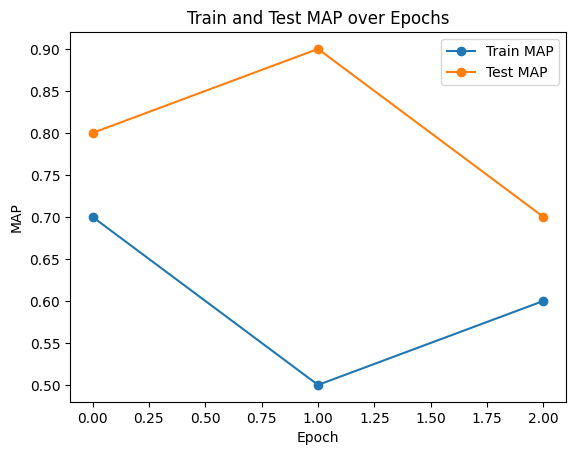

In [9]:
import matplotlib.pyplot as plt

train_map = [0.7, 0.5, 0.6]
test_map = [0.8, 0.9, 0.7]

# 绘制折线图
plt.plot(train_map, label='Train MAP', marker='o')  # 绘制 train_map 的折线，使用圆点标记
plt.plot(test_map, label='Test MAP', marker='o')    # 绘制 test_map 的折线，使用圆点标记

# 添加标签和标题
plt.xlabel('Epoch')
plt.ylabel('MAP')
plt.title('Train and Test MAP over Epochs')

# 添加图例
plt.legend()

# 保存图像
plt.savefig('map_plot.png')

# 显示图像（可选）
plt.show()
